# Project 3: Web APIs and NLP
_By: Kelly Wu (NYC - Tensors)_

## Problem Statement
After a huge success from releaseing Mario Kart Tour, Nintendo is about to release another iteration of Mario Kart and wants to utilize their social media presence to create buzz as users and consumers will already have their phones in hand. The marketing department has to come up with another new and catchy name! However, the office has become split about what word to use. Some say to just use "Mario Kart" because it's known and can create a sense of minimalism. Some are arguing that "Mario Kart" too general for this new release and are throwing out various add-ons to "Mario Kart" like "Mario Kart World" or "Mart Kart 3000." Others are just throwing random words to spice things up like "Luigi Kart," "Mushroom Race," and "Luigi Drive." With a divided office, they managed to all agree on one thing: hire an analyst to help them decide. What word should the marketing team decide on before releasing news about the upcoming Mario Kart? 

## Executive Summary
We begin our process by going to the home of topic conversations: Reddit. There we decided to choose two popular Mario game subreddits: Mario Kart and Smash Bros Ultimate. From those two subreddits, we began by gathering our data through webscraping via 10 request pulls and converting all our findings into a nice data frame to work with in our analysis (which can be found in a separate notebook in the code folder). Afterwards, we saved and exportd our nicely converted data to be imported into a new notebook to begin a cleaning and exploratory data analysis to fix any immediately noticeable values that wouldn't be beneficial to us. 

Here we searched for any outliers and null values that we decided to drop from our dataset as they were only a minute number of rows in our overall collected data. In the end, we had abotu 1850 rows from the Mario Kart subreddit and 1450 rows from the Smash Bros Ultimate subreddit. Next we decided to focus on the titles as we figured that you always get grabbed by a title before actually reading the content. So we dived into lemmatizing-to pull root words from the title words- and count vectorizing to determine the frequency of certain words-single words and consecutive pair words. Afterwards, we looked at the frequency with consideration of an existing set of English stop words to reduce any "noise" (as we don't want common words like "the" or "a" showing up on our list). 

After discovering our potential hashtag words, we went on to a modeling process to see if we could find the best model in prediciting whether it can classify certain titles into the correct subreddit. Our goal here is that we want don't want to select a hashtag that is too ambiguous and won't have an immediate recognition to Mario Kart. Therefore, we have our second subreddit, which is slightly similar, to see how accurate our potential hashtag may be in representing the upcoming Mario Kart and not being confused for Smash Bros Ultimate. Through modeling we explore Naive Bayes and Classifier models and play with some of the hyperparameters to tune and find the best model and come to our conclusion.


## Contents
- [Imports](#Imports)
    - [Import Libraries](#Import-Libraries)
    - [Import Cleaned Data](#Import-Cleaned-Data)
- [Exploratory Data Analysis and Preprocessing](#Exploratory-Data-Analysis-and-Preprocessing)
    - [Outliers and Null Values](#Outliers-and-Null-Values)
    - [Lemmatizing](#Lemmatizing)
    - [Count Vectorizer](#Count-Vectorizer)
        - [Frequency of Single Grams](#Frequency-of-Single-Grams)
        - [Frequency of Bigrams](#Frequency-of-Bigrams)
        - [Frequency of Single Grams with Stop Words](#Frequency-of-Single-Grams-with-Stop-Words)
        - [Frequency of Bigrams with Stop Words](#Frequency-of-Bigrams-with-Stop-Words)
    - [Visualizations](#Visualizations)
- [Modeling](#Modeling)
    - [Combining Data Frames](#Combining-Data-Frames)
    - [Creating Our Variables](#Creating-Our-Variables)
    - [Baseline](#Baseline)
    - [Classifiers](#Classifiers)
        - [Bernoulli Naive Bayes](#Bernoulli-Naive-Bayes)
        - [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
        - [Logistic Regression](#Logistic-Regression)
        - [AdaBoost](#AdaBoost)
    - [Initial Modeling Notes](#Initial-Modeling-Notes)
- [Determining Our Best Model via Pipeline and GridSearch](#Determining-Our-Best-Model-via-Pipeline-and-GridSearch)
    - [Comparing Model Scores](#Comparing-Model-Scores)
    - [Comparing Model Confusion Matrices](#Comparing-Model-Confusion-Matrices)
- [Testing Potential Game Names Classification](#Testing-Potential-Game-Names-Classification)
- [Outside Research](#Outside-Research)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

### Imports

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

#### Import Cleaned Data

In [2]:
mario_kart = pd.read_csv('../datasets/mariokart.csv')
smash = pd.read_csv('../datasets/smashultimate.csv')

### Exploratory Data Analysis and Preprocessing
Here we tackle the surface level data cleaning and analysis to handle any immediate eye catchers so they don't affect our modeling later on. 

#### Outliers and Null Values

In [3]:
# Check to see how many rows of data we have for each subreddit
print(mario_kart.shape)
print(smash.shape)

(1857, 3)
(1453, 3)


In [4]:
# See how many nulls we have
mario_kart.isna().sum()

title         0
selftext     99
subreddit     0
dtype: int64

In [5]:
smash.isna().sum()

title         0
selftext     24
subreddit     0
dtype: int64

In [6]:
def drop_columns(data): 
    data = data.drop(columns = ['selftext'])
    return data 

In [7]:
mario_kart = drop_columns(mario_kart)
smash = drop_columns(smash)

- We can see that there are many null values in each subreddit's dataframes, but since our focus is on the titles and not the content (selftext), we don't have to worry about the existing null values. Therefore, we dropped the entire selftext column.

In [8]:
# Check to see if we possibly have any outliers
mario_kart['title'].sort_values()

851     "The Inserted SD card does not contain CTGP-R....
768     (4th of 4 surveys) How does esports improve th...
1673    (Hyduken) Super MarioKart Hyper street kart 20...
150     (I know Nintendo is Hosting a Tournament at th...
149     (I know Nintendo is Hosting a tournament atm o...
                              ...                        
1681    {Hyduken} Super Mario Kart Hyper Street Kart 2...
313                           {MK7] Tips for Time Trials.
1808                       {MKWii} ctww wont load on ctgp
1103                        “Fire Hopping” and “Snaking”?
1157                                                    🐕
Name: title, Length: 1857, dtype: object

- From sorting our values, we can see that we have one row that has an emoji title instead of words so it isn't useful to us in training a model to classify posts to the correct subreddit. 

In [9]:
# Drop outlier
mario_kart.drop(index = 1157, inplace = True)

In [10]:
# Check to ensure that we dropped our outlier
mario_kart['title'].sort_values()

851     "The Inserted SD card does not contain CTGP-R....
768     (4th of 4 surveys) How does esports improve th...
1673    (Hyduken) Super MarioKart Hyper street kart 20...
150     (I know Nintendo is Hosting a Tournament at th...
149     (I know Nintendo is Hosting a tournament atm o...
                              ...                        
98                                   who are your mains ?
1681    {Hyduken} Super Mario Kart Hyper Street Kart 2...
313                           {MK7] Tips for Time Trials.
1808                       {MKWii} ctww wont load on ctgp
1103                        “Fire Hopping” and “Snaking”?
Name: title, Length: 1856, dtype: object

In [11]:
# Reset our indexes so our data frame isn't missing a row 1157 
# and actually goes in consecutive order again 
# https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-dataframe
mario_kart = mario_kart.reset_index(drop = True)

In [12]:
smash['title'].sort_values()

1288                            "COB" tourney in Seattle?
1329                                    "Heart" codename?
818                          "Overwriting" enemy attacks?
204        "Phantom" - Me, Colored Pens and Pencils, 2019
878                                       #SUPPORT BOCCHI
                              ...                        
575     whats the best spirit team for the spirit tour...
955     why do I get punished for playing against poor...
169                      why do I want Lego yoda in smash
476                           world of light final battle
303                         “Unsporting Behavior” Venting
Name: title, Length: 1453, dtype: object

- We did a basic search for any obvious outliers that may not be useful to our modeling process and found one row in the Mario Kart data, which we dropped. Fortunately, there were no obvious outliers in the Smash Bros Ultimate data. 

In [13]:
# Summary statistics
mario_kart.describe().T

,count,unique,top,freq
title,1856,1856,[MK8DX] Does online track selection change dep...,1
subreddit,1856,1,mariokart,1856


In [14]:
smash.describe().T

,count,unique,top,freq
title,1453,1453,Everyone is hyped for SNK character...,1
subreddit,1453,1,SmashBrosUltimate,1453


#### Lemmatizing
Here we begin the preprocessing. We defined a function to lemmatize and give us a cleaned output for titles that may have inflection forms of words. This process allows us to find the base or root word for varied words. 

In [15]:
def lemmatize(column): 
    # Instantiate tokenizer
    tokenizer = RegexpTokenizer(r'[A-z]+')
    
    # Tokenize text
    tokens = [tokenizer.tokenize(text.lower()) for text in column]
    
    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens_lem = []
   
    # Lemmatize tokens with a for loop
    for words in tokens:
        lem_list = [lemmatizer.lemmatize(i) for i in words] # Create a list where we lemmatize our tokens 
        lem_post = ''                                   
        
        # Adjust lemmatized tokens to still be contained as the original title instead of separate words
        # Code from Noah 
        for word in lem_list: 
            lem_post += (word + ' ')
        tokens_lem.append(lem_post.strip())
    
    return tokens_lem

In [16]:
mario_kart_lem = lemmatize(mario_kart['title'])
smash_lem = lemmatize(smash['title'])

#### Count Vectorizer
Here we define a function where we can specify parameters via function inputs to count up the frequency of the most common words in a given subreddit. 

In [17]:
# Worked with Despina

def mk_word_frequency(stop = None, n_gram = (1,1)):
    # Instantiate Count Vectorizer 
    cvec = CountVectorizer(stop_words = stop, ngram_range = n_gram) 
    
    # Create dataframe based on our previously lemmatized titles
    cvec_df = pd.DataFrame(cvec.fit_transform(mario_kart_lem).toarray(),
                           columns = cvec.get_feature_names())
    
    # Sum up word occurences and sort them from most frequent to least 
    cvec_counts = cvec_df.sum().sort_values(ascending = False)
    return cvec_counts

In [18]:
# Same defined function as above for the Smash Bros Ultimate data 

def smash_word_frequency(stop = None, n_gram = (1,1)):
    cvec = CountVectorizer(stop_words = stop, ngram_range = n_gram)
    cvec_df = pd.DataFrame(cvec.fit_transform(smash_lem).toarray(),
                           columns = cvec.get_feature_names())

    cvec_counts = cvec_df.sum().sort_values(ascending = False)
    return cvec_counts

#### Frequency of Single Grams
Here we are simply calling the functions we defined since we want the single gram without any stop words. 

In [19]:
mk_single = mk_word_frequency()

In [20]:
smash_single = smash_word_frequency()

#### Frequency of Bigrams 
Here we input our `n_gram` to be set to `(2,2)` as we want the bigram count without stop words. 

In [21]:
mk_bigram = mk_word_frequency(n_gram = (2,2))

In [22]:
smash_bigram = smash_word_frequency(n_gram = (2,2))

####  Frequency of Single Grams with Stop Words
Here we input our `stop` to be set to `'english'` as we want the default single gram, while ignoring specific words in the `scikit learn` package such as articles like `the` from being included in our output. 

In [23]:
mk_stop_single = mk_word_frequency(stop = 'english')

In [24]:
smash_stop_single = smash_word_frequency(stop = 'english')

#### Frequency of Bigrams with Stop Words
Here we input our `stop` to be set to `'english'` and our `n_gram` to be set to `(2,2)` for a bigram, while ignoring specific words in the `scikit learn` package such as articles like `the` from being included in our output. 

In [25]:
mk_stop_bigram = mk_word_frequency(stop = 'english', n_gram = (2,2))

In [26]:
smash_stop_bigram = smash_word_frequency(stop = 'english', n_gram = (2,2))

#### Visualizations
After calling the functions for our frequency counts across 4 different parameters, we visualize the top ten most frequent counts as follows. 

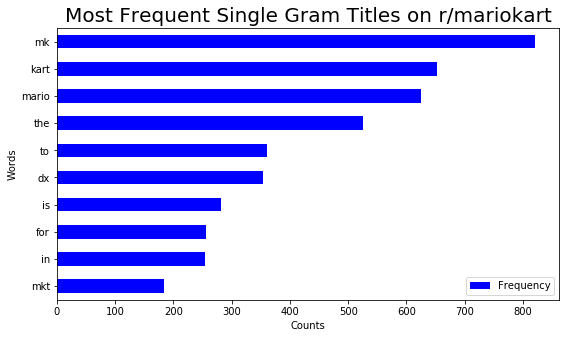

In [27]:
mario_kart_single_frequency = pd.DataFrame(data = mk_single, 
                                           columns = ['Frequency'])

top_10_single = mario_kart_single_frequency.head(10)

top_10_single.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'blue', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Single Gram Titles on r/mariokart',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 1:_

We can see that `mk` is the most frequent single gram word, which is interesting as this tells us many users actually abbreviate Mario Kart, instead of writing out the entire name. In addition, we can see that common article words make up half of our top ten list, which isn't very helpful in determining which word will be best to name the next Mario Kart iteration. 

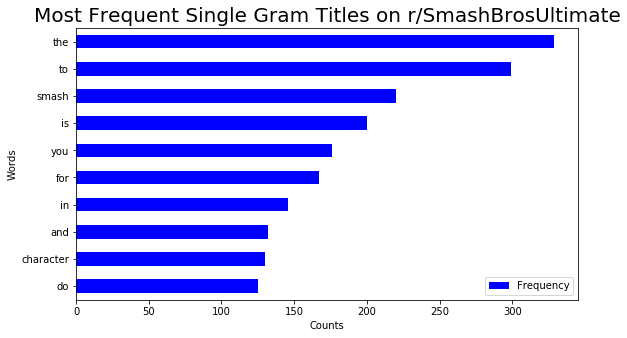

In [28]:
smash_single_frequency = pd.DataFrame(data = smash_single, 
                                         columns = ['Frequency'])

top_10_single = smash_single_frequency.head(10)

top_10_single.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'blue', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Single Gram Titles on r/SmashBrosUltimate',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 2:_

Similarly to Chart 1, the Smash Bros Ultimate data also suffers from common article words being used often in users' post titles, but much more as the only truly standout words that relate to the subreddit are "smash" and "character" while all other words don't seem unique. 

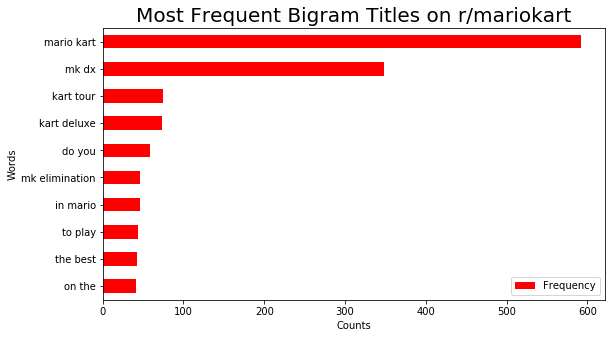

In [29]:
mario_kart_double_frequency = pd.DataFrame(data = mk_bigram, 
                                         columns = ['Frequency'])

top_10_double = mario_kart_double_frequency.head(10)

top_10_double.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'red', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Bigram Titles on r/mariokart',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 3:_

To combat the articles problem, we can view the top ten most frequent bigrams, which are pairs of consecutive words. As shown above, we tend to have less articles popping up, but we still have some appear along with unique words we care for such as `in mario.` However, we don't care much for `on the` which contains two articles.

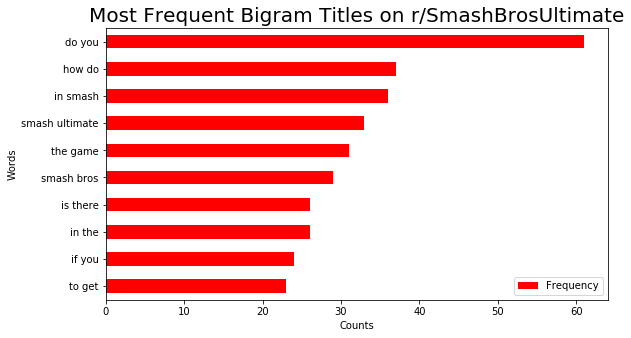

In [30]:
smash_double_frequency = pd.DataFrame(data = smash_bigram, 
                                         columns = ['Frequency'])

top_10_double = smash_double_frequency.head(10)

top_10_double.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'red', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Bigram Titles on r/SmashBrosUltimate',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 4:_

Similarly to Chart 3, we get better results, but the Smash Bros Ultimate data tends to suffer more from these articles. For instance, `do you` appears nearly twice as often as `smash ultimate` which we would expect to be the top bigram considering it is the name of the subreddit. 

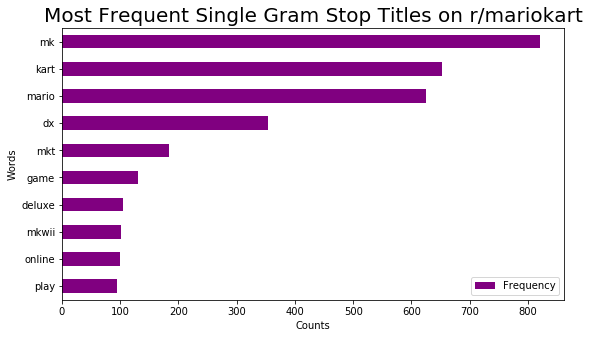

In [31]:
mario_kart_stop_frequency = pd.DataFrame(data = mk_stop_single, 
                                         columns = ['Frequency'])

top_10_stop = mario_kart_stop_frequency.head(10)

top_10_stop.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'purple', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Single Gram Stop Titles on r/mariokart',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 5:_

To combat the articles even further, we have the frequency counts of words excluding the common articles, which helps us much more by giving us more unique words that are more related to the subreddit. One thing to note is that, it seems to be very common for users to abbreviate "Mario Kart" to `mk` and "Deluxe" to `dx` as opposed to writing the entire word. 

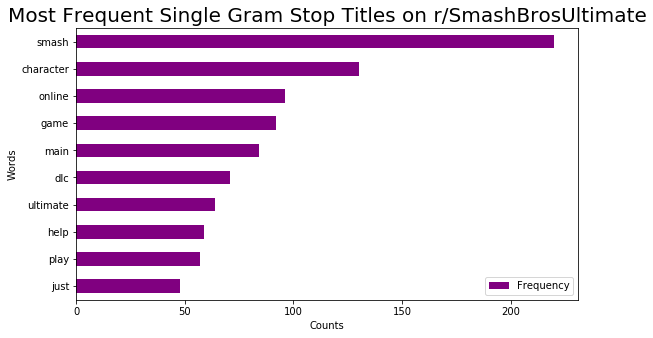

In [32]:
smash_stop_frequency = pd.DataFrame(data = smash_stop_single, 
                                         columns = ['Frequency'])

top_10_stop = smash_stop_frequency.head(10)

top_10_stop.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'purple', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Single Gram Stop Titles on r/SmashBrosUltimate',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 6:_

Similar to Chart 5, we managed to get more unique words related to the subreddit. However, one thing that stands out is that `online` and `play` show up Chart 5 as well. The only difference is that these two words have a higher ranking in this subreddit. 

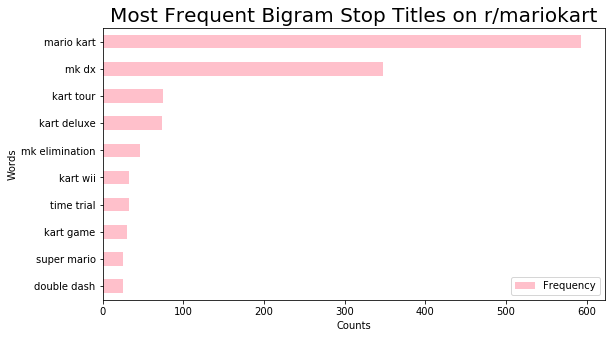

In [33]:
mario_kart_stop_2_frequency = pd.DataFrame(data = mk_stop_bigram, 
                                         columns = ['Frequency'])

top_10_stop = mario_kart_stop_2_frequency.head(10)

top_10_stop.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'pink', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Bigram Stop Titles on r/mariokart',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 7:_

Finally, we try to find our best option in combatting all the issues we have been running into as seen from the other graphs. We take out the articles and look at bigrams, which produces a list of very unique words relevant to the Mario Kart subreddit. We can see that Mario Kart and its abbreviation dominate, but one thing to note is that users also tend to refer to game iterations as `kart + {iteration}.`

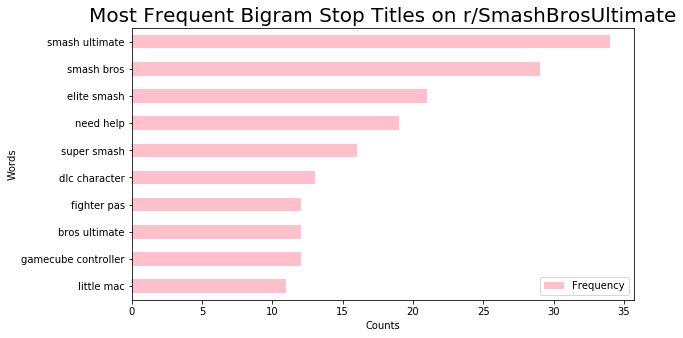

In [34]:
smash_stop_2_frequency = pd.DataFrame(data = smash_stop_bigram, 
                                         columns = ['Frequency'])

top_10_stop = smash_stop_2_frequency.head(10)

top_10_stop.sort_values(by = 'Frequency', ascending = True).plot(kind = 'barh', 
                                                                  color = 'pink', 
                                                                  figsize = (9,5))

plt.title('Most Frequent Bigram Stop Titles on r/SmashBrosUltimate',size = 20)
plt.xlabel('Counts', size = 10)
plt.ylabel('Words', size = 10);

_Chart 8:_

Similar to Chart 7, our adjustments significantly impacted our results as now we have many bigrams that are clearly unique to the subreddit as opposed to more ambiguity that could be applied to other subreddits. 

> **Notes:** From our exploratory analysis, we can start brainstorming some potential game names. Ideally we want to avoid utilizing the words: online, play, and ultimate as they have a higher frequency in the Smash Bros subreddit as opposed to the Mario Kart subreddit. In addition, it would be ideal to include "Mario Kart" in the name mostly for consistency. There are many options so we can still utilize the numerous suggestions that the marketing team is arguing between. 
- Mario Kart World
- Mario Kart 3000
- Luigi Kart
- Mushroom Race
- Luigi Drive 

### Modeling 
Here we begin exploring different models and hyperparameters in order to fit and find the best model for predicting what subreddit a post belongs to based on the title. After identifying the best model, we can test out potential game names and see how they are classified to find our best option. 

#### Combining Data Frames

In [35]:
# Merging the two data sets 
combined_df = pd.concat(objs = [mario_kart, smash], axis = 0)

In [36]:
# Creating an (easier) binary classifier 
combined_df['subreddit'] = combined_df['subreddit'].map({'mariokart': 0, 'SmashBrosUltimate': 1})

In [37]:
# Resetting the indices so the row indexes don't repeat
combined_df.reset_index(drop = True, inplace = True)

In [38]:
combined_df

,title,subreddit
0,Time Trial issues,0
1,Time Trial [MK8DX],0
2,Is my build awful? (MK8DX),0
3,mario kart maker,0
4,Research for a YouTube video I’m working on.,0
...,...,...
3304,Need help against DK and KRool.,1
3305,Practicing with Level 1 CPUs,1
3306,Gambling coins in smash,1
3307,Toon Link: Possible revisions,1


#### Creating Our Variables 
Here we instantiate our variables, where our `X` is the post's title and our `Y` is the subreddit that we are trying to have our model correctly predict. In addition, we split our data randomly into a $\frac{0.66}{0.33}$ proportion where we train our model with majority of the combined data frame to learn and be able to accurately classify the correct subreddit. The we  see how well our model will do when we use the remaining data, which our model hasn't been exposed to, to determine our model's accuracy to new data.

In [39]:
X = combined_df['title']
y = combined_df['subreddit']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.33, random_state = 42)

#### Baseline
We start out with our baseline by looking at our Y variable and since we care about whether our models are able to correct classify a Mario Kart post into the Mario Kart subreddit, we look at the `0` value. Our baseline to (hopefully) beat is 56.09% in terms of accuracy for our models below. 

In [41]:
y.value_counts(normalize = True)

0    0.560895
1    0.439105
Name: subreddit, dtype: float64

#### Classifiers
Since we are prediciting a binary and discrete `y` value, we will be looking at classifier models as opposed to regression models. First, we instantiate the Count Vectorizer in order to transform our `X` variable. Then, we move on to the following four models: Bernoulli NB, Multinomial NB, Logistic Regression, and AdaBoost. 

In [42]:
cvec = CountVectorizer()
cvec_X_train = cvec.fit_transform(X_train).toarray()
cvec_X_test = cvec.transform(X_test).toarray()

#### Bernoulli Naive Bayes

In [43]:
# Instantiate and fit the model 
bnb = BernoulliNB()
bnb.fit(cvec_X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [44]:
# Calculate and print the accuracy of our model and both data sets
print(f'Training Score: {bnb.score(cvec_X_train, y_train)}')
print(f'Testing Score: {bnb.score(cvec_X_test, y_test)}')

Training Score: 0.9657194406856112
Testing Score: 0.8827838827838828


In [45]:
# Predict our y using our model 
bnb_preds = bnb.predict(cvec_X_test)

# Creating a confusion matrix that compares our actual y values versus our predicted y values from the model
bnb_cm = confusion_matrix(y_test, bnb_preds)

In [46]:
# Create dataframe from confusion matrix array
bnb_cm_df = pd.DataFrame(bnb_cm, 
                         columns = ['Predicted Mario Kart', 'Predicted Smash Bros Ultimate'], 
                         index = ['Actual Mario Kart', 'Actual Smash Bros Ultimate'])
bnb_cm_df

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,565,47
Actual Smash Bros Ultimate,81,399


> **Notes:** From the Bernoulli NB model, we can see that the training score shows a 96.57% accuracy, but the testing score shows an 88.28% accuracy, which means that our model is overfit to the training data and doesn't do well in classifying a post into the correct subreddit with new posts. 

#### Multinomial Naive Bayes

In [47]:
# Instantiate and fit the model 
mnb = MultinomialNB()
mnb.fit(cvec_X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [48]:
# Calculate and print the accuracy of our model and both data sets
print(f'Training Score: {mnb.score(cvec_X_train, y_train)}')
print(f'Testing Score: {mnb.score(cvec_X_test, y_test)}')

Training Score: 0.9634641407307172
Testing Score: 0.88003663003663


In [49]:
# Predict our y using our model 
mnb_preds = mnb.predict(cvec_X_test)

# Creating a confusion matrix that compares our actual y values versus our predicted y values from the model
mnb_cm = confusion_matrix(y_test, mnb_preds)

In [50]:
# Create dataframe from confusion matrix array
mnb_cm_df = pd.DataFrame(mnb_cm, 
                         columns = ['Predicted Mario Kart', 'Predicted Smash Bros Ultimate'], 
                         index = ['Actual Mario Kart', 'Actual Smash Bros Ultimate'])
mnb_cm_df

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,568,44
Actual Smash Bros Ultimate,87,393


> **Notes:** From the Multinomial NB model, we can see that the training score shows a 96.35% accuracy, but the testing score shows an 88.00% accuracy, which means that our model is overfit to the training data and doesn't do well in classifying a post into the correct subreddit with new posts (similarly to the Bernoulli NB model). 

#### Logistic Regression


In [51]:
# Instantiate and fit the model 
log = LogisticRegression()
log.fit(cvec_X_train, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
# Calculate and print the accuracy of our model and both data sets
print(f'Training Score: {log.score(cvec_X_train, y_train)}')
print(f'Testing Score: {log.score(cvec_X_test, y_test)}')

Training Score: 0.9756427604871448
Testing Score: 0.9056776556776557


In [53]:
# Predict our y using our model 
log_preds = log.predict(cvec_X_test)

# Creating a confusion matrix that compares our actual y values versus our predicted y values from the model
log_cm = confusion_matrix(y_test, log_preds)

In [54]:
# Create dataframe from confusion matrix array
log_cm_df = pd.DataFrame(log_cm, 
                         columns = ['Predicted Mario Kart', 'Predicted Smash Bros Ultimate'], 
                         index = ['Actual Mario Kart', 'Actual Smash Bros Ultimate'])
log_cm_df

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,521,91
Actual Smash Bros Ultimate,12,468


> **Notes:** From the Logistic Regression model, we can see that the training score shows a 97.56% accuracy, but the testing score shows an 90.57% accuracy, which means that our model is still overfit to the training data and doesn't do well in classifying a post into the correct subreddit with new posts. However, it is our best model so far, with the smallest difference between the two accuracy scores.

#### AdaBoost Classifier

In [55]:
# Instantiate and fit the model 
ada = AdaBoostClassifier()
ada.fit(cvec_X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [56]:
# Calculate and print the accuracy of our model and both data sets
print(f'Training Score: {ada.score(cvec_X_train, y_train)}')
print(f'Testing Score: {ada.score(cvec_X_test, y_test)}')

Training Score: 0.9197113216057735
Testing Score: 0.8992673992673993


In [57]:
# Predict our y using our model 
ada_preds = ada.predict(cvec_X_test)

# Creating a confusion matrix that compares our actual y values versus our predicted y values from the model
ada_cm = confusion_matrix(y_test, ada_preds)

In [58]:
# Create dataframe from confusion matrix array
ada_cm_df = pd.DataFrame(ada_cm, 
                         columns = ['Predicted Mario Kart', 'Predicted Smash Bros Ultimate'], 
                         index = ['Actual Mario Kart', 'Actual Smash Bros Ultimate'])
ada_cm_df

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,511,101
Actual Smash Bros Ultimate,9,471


> **Notes:** From the AdaBoost Classifier model, we can see that the training score shows a 91.97% accuracy, but the testing score shows an 89.93% accuracy, which means that our model isn't as overfit as the other 3 models to the training data and does do well in classifying a post into the correct subreddit with new posts.

#### Initial Modeling Notes
From our four models above, the AdaBoost Classifier would be our best model as it does fairly well in classifying posts into the correct subreddit in both the training and testing data sets. However, this is only based on the Count Vectorizer transformer along with no parameters for our classifiers. Tuning our hyperparameters could possibly result in a better model. 

### Determining Our Best Model via Pipeline and GridSearch
Here we begin to tune our intial models by introducing a new transformer and specifying parameters that we explored earlier regarding the `n_gram range` and `stop_words` for our transformers in order to determine our best model. 

In [59]:
tvec = TfidfVectorizer()

In [60]:
cvec_pipe_params = {
    'cvec__ngram_range' : [(1,1), (1,2)],
    'cvec__stop_words' : [None, 'english']
}

In [61]:
tfidf_pipe_params = {
    'tfidf__ngram_range' : [(1,1), (1,2)],
    'tfidf__stop_words' : [None, 'english']
}

***Count Vectorizer and Bernoulli NB***

In [62]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

gs = GridSearchCV(pipe1, cvec_pipe_params, cv = 5)
gs.fit(X_train, y_train);
cvec_bnb_model = gs.best_estimator_

***TFIDF Vectorizer and Bernoulli NB***

In [63]:
pipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

gs = GridSearchCV(pipe2, tfidf_pipe_params, cv = 5)
gs.fit(X_train, y_train);
tfidf_bnb_model = gs.best_estimator_

***Count Vectorizer and Multinomial NB***

In [64]:
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

gs = GridSearchCV(pipe3, cvec_pipe_params, cv = 5)
gs.fit(X_train, y_train);
cvec_mnb_model = gs.best_estimator_

***TFIDF Vectorizer and Multinomial NB***

In [65]:
pipe4 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

gs = GridSearchCV(pipe4, tfidf_pipe_params, cv = 5)
gs.fit(X_train, y_train);
tfidf_mnb_model = gs.best_estimator_

***Count Vectorizer and Logistic Regression***

In [66]:
pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression())
])

gs = GridSearchCV(pipe5, cvec_pipe_params, cv = 5)
gs.fit(X_train, y_train);
cvec_log_model = gs.best_estimator_

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

***TFIDF Vectorizer and Logistic Regression***

In [67]:
pipe6 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('log', LogisticRegression())
])

gs = GridSearchCV(pipe6, tfidf_pipe_params, cv = 5)
gs.fit(X_train, y_train);
tfidf_log_model = gs.best_estimator_

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

***Count Vectorizer and AdaBoost Classifier***

In [68]:
pipe7 = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier())
])

gs = GridSearchCV(pipe7, cvec_pipe_params, cv = 5)
gs.fit(X_train, y_train);
cvec_ada_model = gs.best_estimator_

***TFIDF Vectorizer and AdaBoost Classifier***

In [69]:
pipe8 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

gs = GridSearchCV(pipe8, tfidf_pipe_params, cv = 5)
gs.fit(X_train, y_train);
tfidf_ada_model = gs.best_estimator_

#### Comparing Model Scores

Here we print out all the possible model scores that we have instantiated. 

***Bernoulli NB***

In [70]:
print(f'Count Vectorizer Training Score: {cvec_bnb_model.score(X_train, y_train)}')
print(f'Count Vectorizer Testing Score: {cvec_bnb_model.score(X_test, y_test)}')
print('')
print(f'TFIDF Vectorizer Training Score: {tfidf_bnb_model.score(X_train, y_train)}')
print(f'TFIDF Vectorizer Testing Score: {tfidf_bnb_model.score(X_test, y_test)}')

Count Vectorizer Training Score: 0.970681100586378
Count Vectorizer Testing Score: 0.9075091575091575

TFIDF Vectorizer Training Score: 0.970681100586378
TFIDF Vectorizer Testing Score: 0.9075091575091575


**Notes:** We can see that the training and testing scores for both vectorizers are identical, which means that the type of vectorizer does not have an effect on the model. In addition, we can see that the training score entails that our model is 97.07% accurate, but the testing score is only 90.75%, which means our model is overfit. 

***Multinomial NB***

In [71]:
print(f'Count Vectorizer Training Score: {cvec_mnb_model.score(X_train, y_train)}')
print(f'Count Vectorizer Testing Score: {cvec_mnb_model.score(X_test, y_test)}')
print('')
print(f'TFIDF Vectorizer Training Score: {tfidf_mnb_model.score(X_train, y_train)}')
print(f'TFIDF Vectorizer Testing Score: {tfidf_mnb_model.score(X_test, y_test)}')

Count Vectorizer Training Score: 0.9634641407307172
Count Vectorizer Testing Score: 0.8855311355311355

TFIDF Vectorizer Training Score: 0.9621109607577808
TFIDF Vectorizer Testing Score: 0.8672161172161172


**Notes:** We can see that the training and testing scores for both vectorizers are different, which means that the type of vectorizer does have an effect on the model. For the Multinomial NB model, it does better with the Count Vectorizer. As seen, the training scores for both vectorizers are practically identical. However, the Count Vectorizer has a higher testing score of 88.55% versus 86.72%, which means the model is more accurate with classifying new posts into the correct subreddit. However, both models are still overfit. 

***Logistic Regression***

In [72]:
print(f'Count Vectorizer Training Score: {cvec_log_model.score(X_train, y_train)}')
print(f'Count Vectorizer Testing Score: {cvec_log_model.score(X_test, y_test)}')
print('')
print(f'TFIDF Vectorizer Training Score: {tfidf_log_model.score(X_train, y_train)}')
print(f'TFIDF Vectorizer Testing Score: {tfidf_log_model.score(X_test, y_test)}')

Count Vectorizer Training Score: 0.9697789806044204
Count Vectorizer Testing Score: 0.9157509157509157

TFIDF Vectorizer Training Score: 0.968425800631484
TFIDF Vectorizer Testing Score: 0.9212454212454212


**Notes:** We can see that the training and testing scores for both vectorizers are different, which means that the type of vectorizer does have an effect on the model. For the Logistic Regression model, it does better with the TFIDF Vectorizer. As seen, the training scores for both vectorizers are practically identical. However, the TFIDF Vectorizer has a higher testing score of 92.12% versus 91.58%, which means the model is more accurate with classifying new posts into the correct subreddit. However, both models are still slightly overfit, but does significantly better than the Naive Bayes models. 

***AdaBoost Classifier***

In [73]:
print(f'Count Vectorizer Training Score: {cvec_ada_model.score(X_train, y_train)}')
print(f'Count Vectorizer Testing Score: {cvec_ada_model.score(X_test, y_test)}')
print('')
print(f'TFIDF Vectorizer Training Score: {tfidf_ada_model.score(X_train, y_train)}')
print(f'TFIDF Vectorizer Testing Score: {tfidf_ada_model.score(X_test, y_test)}')

Count Vectorizer Training Score: 0.92106450157871
Count Vectorizer Testing Score: 0.9038461538461539

TFIDF Vectorizer Training Score: 0.9246729815065403
TFIDF Vectorizer Testing Score: 0.9029304029304029


**Notes:** We can see that the training and testing scores for both vectorizers are different, which means that the type of vectorizer does have an effect on the model. For the AdaBoost Classifier model, the training scores and testing scores for both vectorizers are practically identical. However, when comparing how close the training and testing scores are to each other when accounting for variance, the Count Vectorizer does slightly better. While the scores are not as high as the Logistic Regression model, the AdaBoost Classifier model, seems to be our best regarding the Bia-Variance Tradeoff. 

#### Comparing Model Confusion Matrices

Here we utilize each of our tuned models to predict our `y` values based on our `X` values from our testing data set. Under each type of model, the first confusion matrix is with the Count Vectorizer and the second confusion matrix is with the TFIDF Vectorizer. We define a function in order to output a confusion matrix. 

In [74]:
def matrix(model):
    # Predict y values from selected model
    y_test_preds = model.predict(X_test)
    
    # Create confusion matrix array
    cm = confusion_matrix(y_test, y_test_preds)
    
    # Convert array to pandas data frame
    cm_df = pd.DataFrame(cm, 
                         columns = ['Predicted Mario Kart', 'Predicted Smash Bros Ultimate'], 
                         index = ['Actual Mario Kart', 'Actual Smash Bros Ultimate'])
    return cm_df

***Bernoulli NB***

We can see that there's an equal about of Type I and Type II errors, so there may be some words that are highly common on both subreddits inducing these misclassifications such as "online" and "play."

In [75]:
# Count Vectorizer
matrix(cvec_bnb_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,562,50
Actual Smash Bros Ultimate,51,429


In [76]:
# TFIDF Vectorizer 
matrix(tfidf_bnb_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,562,50
Actual Smash Bros Ultimate,51,429


***Multinomial NB*** 

Unlike the Bernoulli NB model, we can see that the Multinomial NB model is misclassifying more Smash Bros Ultimate posts than vice versa. 

In [77]:
# Count Vectorizer
matrix(cvec_mnb_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,574,38
Actual Smash Bros Ultimate,87,393


In [78]:
# TFIDF Vectorizer 
matrix(tfidf_mnb_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,587,25
Actual Smash Bros Ultimate,120,360


***Logistic Regression***

Similarly to the Multinomial NB model, we can see that the Logistic Regression model does the opposite regarding Type I and Type II errors. This model is misclassifying more Mario Kart posts than vice versa. 

In [79]:
# Count Vectorizer
matrix(cvec_log_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,529,83
Actual Smash Bros Ultimate,9,471


In [80]:
# TFIDF Vectorizer 
matrix(tfidf_log_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,538,74
Actual Smash Bros Ultimate,12,468


***AdaBoost Classifier***

Similarly to the Logistic Regression model, we can see that the AdaBoost Classifier model is misclassifying more Mario Kart posts than vice versa. However, the misclassification numbers are nearly identical, which is where our Bias-Variance Tradeoff comes in. Our model performs almost as well with data it's been trained on versus data it has never seen. 

In [81]:
# Count Vectorizer
matrix(cvec_ada_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,513,99
Actual Smash Bros Ultimate,6,474


In [82]:
# TFIDF Vectorizer 
matrix(tfidf_ada_model)

,Predicted Mario Kart,Predicted Smash Bros Ultimate
Actual Mario Kart,513,99
Actual Smash Bros Ultimate,7,473


### Testing Potential Game Names Classification
Through our analyzing all our different models, our best model is the Count Vectorizer and AdaBoost Classifier. With this model, our goal is to test the names the marketing team is arguing amongst to see if we can knock out any contenders. 

In [83]:
ideal_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier())
])

gs = GridSearchCV(ideal_pipe, cvec_pipe_params, cv = 5)
gs.fit(X_train, y_train);
best_model = gs.best_estimator_

In [86]:
potential_names = [
    {'title': 'mario kart world', 'subreddit': 0}, 
    {'title': 'mario kart 3000', 'subreddit': 0}, 
    {'title': 'luigi kart', 'subreddit': 0}, 
    {'title': 'mushroom race', 'subreddit': 0}, 
    {'title': 'luigi drive', 'subreddit': 0}          
]

potential_df = pd.DataFrame(potential_names)

X = potential_df['title']
y = potential_df['subreddit']
predictions = best_model.predict(X)

predictions

array([0, 0, 0, 1, 1])

**Notes:** From our model, we can immediately knock out "Mushroom Race" and "Luigi Drive" as contenders for the next Mario Kart iteration game name as it would be classified to the Smash Bros Ultimate subreddit instead of the Mario Kart subreddit. 

### Outside Research
What is Reddit? Reddit is home to thousands of communities, endless conversation, an authentic human connection. Whether you're into breaking news, sports, TV fan theories, or a never-ending stream of the internet's cutest animals, there's a community on Reddit for you. 

How does Reddit Work? Every day, millions of people around the world post, vote, and comment in communities organized around their interests. 
- Post: The community can share content by posting stories, links, images, and videos.
- Comment: The community comments on posts. Comments provide discussion and often humor. 
- Vote: Comments & posts can be upvoted or downvoted. The most interesting content rises to the top. 

**Mario Kart Subreddit**

> About Community: 
- 63.7k racers
- Created on January 12, 2011

Subreddit Rules: 
1. No unsourced artwork
2. No low-quality posts 
3. No unapproved self-advertisements
4. No NSFW posts

Filters: 
- Discussion
- Meta
- Humor 
- Replay/Clip
- News/Article
- Competitive
- Fan Content
- Achievement 

There are many rules for the Mario Kart subreddit where the general basis is to post PG quality related posts. As we can see, there are numerous filters so there isn't a very consistent discussion going on as it spreads across various topics. 

**Smash Bros Ultimate Subreddit**

> About Community: 
- 292k returning veterans
- Created on June 12, 2018

Subreddit Rules: 
1. Be excellent to one another
2. No low-effort/misleading posts
3. No off topic posts
4. Keep it clean
5. No advertising or self-promotion
6. Mark spoilers
7. No reposts
8. No stolen content

Filters: 
- Meme/Funny
- Image/Gif
- Video
- Fan Made
- Speculation
- Official News

Unlike the Mario Kart subreddit, the Smash Bros Ultimate subreddit has many more rules to help steer discussions or posts in a specific direction. As a result, there are also fewer filters, especially considering the fact that there is over 3 times the number of Reddit users in the community. It shows that there is a high amount of consistency across posts. 

### Conclusion and Recommendations
After exploring a few different models and tuning those models by playing with the hyperparameters, we discovered that our Count Vectorizer AdaBoost Classifier model is ideal in differentiating titles into the correct reddit as it is 92.11% accurate in classifying our training set and 90.38% accurate in classifying our testing set. As shown in the table below, we can see all the training and testing model accuracy scores. While our Count Vectorizer AdaBoost Classifier model doesn't necessarily have the highest scores, we care more about the two scores being as close together as possible because it shows that our model isn't overfit to our training data. For instance, if we look at the Multinomial NB model, the training score is quite high with a 95.49% accuracy, but the testing score is nearly 10 points lower at 84.54% accuracy, which means that this model is very overfit to the training data set and doesn't do well in classifying new titles into the correct subreddit. Overall, our Count Vectorizer AdaBoost Classifier model still does fairly well considering that it managed to predict about 90% of our titles to the correct subreddit out of a sample of over 3000 rows (which means that it was inaccurate on about 300 rows). 

|Model|Training Score|Testing Score|
|---|---|---|
|Bernoulli NB|0.9657|0.8828|
|Bernoulli NB (CVEC)|0.9707|0.9075|
|Bernoulli NB (TFIDF)|0.9707|0.9075|
|Multinomial NB|0.9635|0.8800|
|Multinomial NB (CVEC)|0.9635|0.8855|
|Multinomial NB (TFIDF)|0.9621|0.8672|
|Logistic Regression|0.9756|0.9057|
|Logistic Regression (CVEC)|0.9698|0.9158|
|Logistic Regression (TFIDF)|0.9684|0.9212|
|AdaBoost Classifier|0.9197|0.8993|
|AdaBoost Classifier (CVEC)|0.9211|0.9038|
|AdaBoost Classifier (TFIDF)|0.9247|0.9029|

However, we do need to consider that this is still a relatively "surface level" model so there are downfalls to this model. Primarily, our model is only catered to two specific subreddits: Mario Kart and Smash Bros Ultimate. Therefore, we can't apply this model to other subreddits such as Mario Party or Super Mario Bros unless we make some modifications. In addition, we could also tune our hyperparameters further as we are only exploring four hyperparameters out of a myriad of possible combinations that could increase our model's accuracy so it can learn more and be capable of thinking more like a human. Furthermore, this data is also time based as recommendations made today may not be the same a year from now as these subreddits are constantly growing and topics may change. 

Overall, we suggest that Nintendo market their new Mario Kart game as essentially the title. We were able to minimize the number of options being discussed to "Mario Kart World," "Mario Kart 3000," and 'Luigi Kart." We discovered in the Mario Kart subreddit, the word "kart" (when looking at a single word option) or "mario kart" (when looking at a consecutive two word option) were the most popular to maintaining that name consistency would be best as opposed to introducing "Mushroom Race" or "Luigi Drive". Building off of the consecutive two word option, the next couple most common word combinations are: "kart tour" and "kart deluxe" which refer to the latest, Mario Kart Tour, and Mario Kart Deluxe 8, respectively. Therefore, the marketing team may want to keep in mind about having an add-on so we wouldn't recommend "Luigi Kart." Additionally, we recommend refraining from including numbers in the name based on the sole foundation of what we discovered from Mario Kart 8 Deluxe being referred to as "mario kart deluxe" instead of "mario kart 8." As a result, "Mario Kart World" would probably be the best option. 